In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import random

In [4]:
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE

In [5]:
#for reproducibility
seed = 39283
np.random.seed(seed)
random.seed(seed)

In [6]:
def kfoldCrossVal(model):
    tr_avg, val_avg = 0, 0
    
    for fold, (tr_idx, val_idx) in enumerate(kfold.split(xtrain, ytrain), start=1):
        x_train, y_train = xtrain.iloc[tr_idx], ytrain.iloc[tr_idx]
        x_val, y_val = xtrain.iloc[val_idx], ytrain.iloc[val_idx]
        
        if model.__class__.__name__ == 'RandomForestRegressor':
            model.fit(x_train, y_train)
        else:
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], 
                          verbose=False, early_stopping_rounds=200)
    
        #predictions
        tr_rmse = MSE(y_train**2, model.predict(x_train)**2, squared=False)
        val_rmse = MSE(y_val**2, model.predict(x_val)**2, squared=False)
        
        tr_avg += tr_rmse
        val_avg += val_rmse
        
        print('Train RMSE: {:.4f}\tVal RMSE: {:.4f}'.format(tr_rmse, val_rmse))
        
    print('AVG. Train RMSE: {:.4f}\t AVG. Val RMSE: {:.4f}'.format(tr_avg/fold, val_avg/fold))

In [7]:
def kfoldCrossValPred(model):
    tr_avg, val_avg = 0, 0
    test_scores = []
    
    for fold, (tr_idx, val_idx) in enumerate(kfold.split(X, y), start=1):
        x_train, y_train = X.iloc[tr_idx], y.iloc[tr_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if model.__class__.__name__ == 'RandomForestRegressor':
            model.fit(x_train, y_train)
        else:
            model.fit(x_train, y_train, eval_set=[(x_val, y_val)], 
                          verbose=False, early_stopping_rounds=200)
    
        #predictions
        tr_rmse = MSE(y_train**2, model.predict(x_train)**2, squared=False)
        val_rmse = MSE(y_val**2, model.predict(x_val)**2, squared=False)
        
        tr_avg += tr_rmse
        val_avg += val_rmse        
        print('Train RMSE: {:.4f}\tVal RMSE: {:.4f}'.format(tr_rmse, val_rmse))
        
        pred = model.predict(test_c)
        test_scores.append(pred)
        
    print('AVG. Train RMSE: {:.4f}\t AVG. Val RMSE: {:.4f}'.format(tr_avg/fold, val_avg/fold))
    return np.mean(test_scores, 0)

In [8]:
pd.set_option('display.max_columns', 100)
%matplotlib inline
plt.style.use('ggplot')

In [9]:
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')
subfile = pd.read_csv(path+'/SampleSubmission.csv')

In [10]:
test_id = test.Item_Store_ID

In [11]:
train.head(3)

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,Item_Store_Returns
0,DRA12,BABATUNJI010,DRA12_BABATUNJI010,11.6,Low Sugar,0.068535,Soft Drinks,357.54,2005,NaN,Cluster 3,Grocery Store,709.08
1,DRA12,BABATUNJI013,DRA12_BABATUNJI013,11.6,Low Sugar,0.040912,Soft Drinks,355.79,1994,High,Cluster 3,Supermarket Type1,6381.69
2,DRA12,BABATUNJI017,DRA12_BABATUNJI017,11.6,Low Sugar,0.041178,Soft Drinks,350.79,2014,NaN,Cluster 2,Supermarket Type1,6381.69


In [12]:
test.head(3)

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type
0,DRA59,BABATUNJI010,DRA59_BABATUNJI010,8.27,Normal Sugar,0.214125,Soft Drinks,459.98,2005,NaN,Cluster 3,Grocery Store
1,DRA59,BABATUNJI013,DRA59_BABATUNJI013,8.27,Normal Sugar,0.127821,Soft Drinks,464.98,1994,High,Cluster 3,Supermarket Type1
2,DRB01,BABATUNJI013,DRB01_BABATUNJI013,7.39,Low Sugar,0.082171,Soft Drinks,477.38,1994,High,Cluster 3,Supermarket Type1


In [13]:
train.shape, test.shape

((4990, 13), (3532, 12))

In [14]:
train.isna().sum()[(train.isna().sum() > 0)]

Item_Weight     802
Store_Size     1450
dtype: int64

In [15]:
test.isna().sum()[(test.isna().sum() > 0)]

Item_Weight    661
Store_Size     959
dtype: int64

Filling missing Item weight with mean weight for an item

In [16]:
df = train.append(test)[train.columns]

In [17]:
df['mean_ItemWt'] = df.groupby(['Item_ID']).Item_Weight.transform('mean')

In [18]:
df.loc[df.Item_Weight.isna(), 'Item_Weight'] = df.loc[df.Item_Weight.isna(), 'mean_ItemWt']

In [19]:
df.Item_Weight.fillna(df.Item_Weight.median(), inplace=True)

In [20]:
for col in df.select_dtypes('object').columns:
    df[col] = df[col].factorize(sort=True)[0]

In [21]:
cat_cols = train.select_dtypes('object').columns.drop('Store_Size')
cat_cols

Index(['Item_ID', 'Store_ID', 'Item_Store_ID', 'Item_Sugar_Content',
       'Item_Type', 'Store_Location_Type', 'Store_Type'],
      dtype='object')

In [22]:
train = df[df.Item_Store_Returns.notna()]
test = df[df.Item_Store_Returns.isna()].drop('Item_Store_Returns', 1)

In [23]:
train.shape, test.shape

((4990, 14), (3532, 13))

In [24]:
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

#### Modelling

In [26]:
train.columns

Index(['Item_ID', 'Store_ID', 'Item_Store_ID', 'Item_Weight',
       'Item_Sugar_Content', 'Item_Visibility', 'Item_Type', 'Item_Price',
       'Store_Start_Year', 'Store_Size', 'Store_Location_Type', 'Store_Type',
       'Item_Store_Returns', 'mean_ItemWt'],
      dtype='object')

In [25]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [27]:
def crossvalscore(model):
    cvs = cross_val_score(model, xtrain, ytrain, scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-cvs.mean())
    std = cvs.std()
    print('RMSE: {0:.4f}+-{1:.4f}'.format(rmse, std))

In [28]:
X = train.drop(['Item_Store_Returns', 'mean_ItemWt'], 1)
y = np.sqrt(train.Item_Store_Returns)
test_c = test.drop('mean_ItemWt', 1)

In [29]:
xtrain, xval, ytrain, yval = train_test_split(X,y,test_size=0.18, random_state=seed)

In [36]:
catm = cat.CatBoostRegressor(random_seed=seed, iterations=800, eval_metric='RMSE', silent=True, max_depth=3,
                             bootstrap_type='Bernoulli', od_wait=200, rsm=0.8, cat_features=cat_cols, reg_lambda=7)
lgbm = lgb.LGBMRegressor(random_state=seed, n_estimators=500, learning_rate=0.03, metrics='rmse', reg_lambda=5,
                         subsample_freq=2, subsample=0.7, colsample_bytree=0.8, max_depth=3, min_child_samples=10, 
                         num_leaves=40, reg_alpha=4)
xgbm = xgb.XGBRegressor(random_state=seed, n_estimators=800, learning_rate=0.05, eval_metric='rmse', max_depth=3,
                        n_jobs=-1, min_child_weight=10, colsample_bytree=0.8, reg_lambda=5,
                        subsample=0.9, missing=-999)

I did a quick Random grid search of the parameters, getting the optimal parameters: below

In [ ]:
xgb_params = {'subsample': 1, 'reg_lambda': 5,'n_estimators': 600, 'min_child_weight': 10,
              'max_depth': 3,'learning_rate': 0.05, 'colsample_bytree': 0.8, 'n_jobs':-1}

lgb_params= {'subsample': 1,'reg_lambda': 7, 'num_leaves': 40, 'n_estimators': 800, 'min_child_weight': 15,
             'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.07, 'colsample_bytree': 0.7}

cat_params = {'subsample': 0.7,'rsm': 1,'reg_lambda': 5,'min_child_samples': 5, 'max_depth': 4, 'iterations': 700,
              'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli'}

In [ ]:
catm = cat.CatBoostRegressor(**cat_params, random_seed=seed, eval_metric='RMSE', silent=True, od_wait=200,)
lgbm = lgb.LGBMRegressor(**lgb_params, random_state=seed, subsample_freq=2, metric='rmse')
xgbm = xgb.XGBRegressor(**xgb_params, random_state=seed, eval_metric='rmse', missing=-999)

In [67]:
kfoldCrossVal(catm)

Train RMSE: 2922.6171	Val RMSE: 2647.7969
Train RMSE: 2796.5668	Val RMSE: 3150.9272
Train RMSE: 2830.2300	Val RMSE: 3177.2198
Train RMSE: 2886.7062	Val RMSE: 2951.5127
Train RMSE: 2857.8406	Val RMSE: 2866.8962
Train RMSE: 2735.4747	Val RMSE: 2705.6834
Train RMSE: 2869.8309	Val RMSE: 2606.7636
Train RMSE: 2888.1034	Val RMSE: 2987.4723
Train RMSE: 2834.6566	Val RMSE: 3300.2369
Train RMSE: 2836.2588	Val RMSE: 2911.5744
AVG. Train RMSE: 2845.8285	 AVG. Val RMSE: 2930.6083


In [68]:
kfoldCrossVal(xgbm)

Train RMSE: 2980.0773	Val RMSE: 2693.5094
Train RMSE: 2703.4750	Val RMSE: 3142.7600
Train RMSE: 2821.4494	Val RMSE: 3185.1628
Train RMSE: 2859.8950	Val RMSE: 2961.3174
Train RMSE: 2799.6617	Val RMSE: 2888.5705
Train RMSE: 2703.6360	Val RMSE: 2703.9018
Train RMSE: 2845.8356	Val RMSE: 2640.4148
Train RMSE: 2818.6146	Val RMSE: 2949.5038
Train RMSE: 2772.0999	Val RMSE: 3354.3755
Train RMSE: 2838.5416	Val RMSE: 2894.5658
AVG. Train RMSE: 2814.3286	 AVG. Val RMSE: 2941.4082


In [93]:
kfoldCrossVal(lgbm)

Train RMSE: 2922.4271	Val RMSE: 2643.0835
Train RMSE: 2840.0942	Val RMSE: 3158.3190
Train RMSE: 2864.6148	Val RMSE: 3175.3265
Train RMSE: 2875.7540	Val RMSE: 2962.3000
Train RMSE: 2840.5244	Val RMSE: 2867.3857
Train RMSE: 2840.9133	Val RMSE: 2744.1487
Train RMSE: 2837.1890	Val RMSE: 2642.7754
Train RMSE: 2845.1726	Val RMSE: 2954.0453
Train RMSE: 2809.8497	Val RMSE: 3341.1053
Train RMSE: 2859.3604	Val RMSE: 2900.6548
AVG. Train RMSE: 2853.5900	 AVG. Val RMSE: 2938.9144


#### Predictions

In [70]:
cat_pred = kfoldCrossValPred(catm)

Train RMSE: 2875.7325	Val RMSE: 2898.9720
Train RMSE: 2840.6168	Val RMSE: 3084.6984
Train RMSE: 2803.5812	Val RMSE: 3249.4355
Train RMSE: 2739.3863	Val RMSE: 2884.1308
Train RMSE: 2917.3684	Val RMSE: 2777.5222
Train RMSE: 2852.3630	Val RMSE: 2785.8679
Train RMSE: 2918.3108	Val RMSE: 2979.2235
Train RMSE: 2904.4052	Val RMSE: 2762.0267
Train RMSE: 2891.3756	Val RMSE: 2905.0445
Train RMSE: 2862.4490	Val RMSE: 2965.3211
AVG. Train RMSE: 2860.5589	 AVG. Val RMSE: 2929.2243


In [71]:
xgb_pred = kfoldCrossValPred(xgbm)

Train RMSE: 2893.6380	Val RMSE: 2933.7915
Train RMSE: 2811.6781	Val RMSE: 3069.5796
Train RMSE: 2762.1107	Val RMSE: 3278.1193
Train RMSE: 2786.0911	Val RMSE: 2898.7056
Train RMSE: 2860.6253	Val RMSE: 2791.0177
Train RMSE: 2856.8719	Val RMSE: 2811.6777
Train RMSE: 2739.9198	Val RMSE: 2978.8419
Train RMSE: 2764.9371	Val RMSE: 2737.4791
Train RMSE: 2884.1194	Val RMSE: 2904.5078
Train RMSE: 2767.6642	Val RMSE: 2952.4627
AVG. Train RMSE: 2812.7656	 AVG. Val RMSE: 2935.6183


In [94]:
lgb_pred = kfoldCrossValPred(lgbm)

Train RMSE: 2896.9823	Val RMSE: 2912.4423
Train RMSE: 2843.4677	Val RMSE: 3059.0423
Train RMSE: 2818.9535	Val RMSE: 3273.5575
Train RMSE: 2819.4405	Val RMSE: 2890.0307
Train RMSE: 2843.6241	Val RMSE: 2775.1065
Train RMSE: 2866.8088	Val RMSE: 2807.7189
Train RMSE: 2881.2585	Val RMSE: 2997.4564
Train RMSE: 2883.7064	Val RMSE: 2767.3973
Train RMSE: 2853.6232	Val RMSE: 2900.8766
Train RMSE: 2856.6132	Val RMSE: 2968.6090
AVG. Train RMSE: 2856.4478	 AVG. Val RMSE: 2935.2237


In [95]:
blend = (0.3 * cat_pred ) + (0.4 * ((xgb_pred + lgb_pred) /2) + (0.3 * xgb_pred)) 

### Submissions

In [96]:
lgb_df = pd.DataFrame({'Item_Store_ID' : test_id, 'Item_Store_Returns' : lgb_pred **2})
cat_df = pd.DataFrame({'Item_Store_ID' : test_id, 'Item_Store_Returns' : cat_pred **2})
xgb_df = pd.DataFrame({'Item_Store_ID' : test_id, 'Item_Store_Returns' : xgb_pred **2})
blend_df = pd.DataFrame({'Item_Store_ID' : test_id, 'Item_Store_Returns' : blend **2})

In [97]:
pd.DataFrame(np.c_[cat_pred, lgb_pred, xgb_pred, blend]**2, columns=['CAT', 'LGB', 'XGB', 'BLEND'])

,CAT,LGB,XGB,BLEND
0,1096.727595,1257.937599,1058.945752,1108.841375
1,7371.548490,6592.750303,6795.131345,6924.363597
2,7025.799442,6503.309898,6280.200937,6544.566259
3,1057.786822,1296.698736,1038.483226,1093.742924
4,7199.696193,6454.828147,6283.486829,6586.608044
...,...,...,...,...
3527,1375.985238,1912.711582,2021.344234,1793.935498
3528,9311.617376,8294.310955,8920.931631,8909.279901
3529,9273.000748,8815.379108,8981.842490,9035.123966
3530,1065.670995,1578.578255,1517.477902,1385.109562


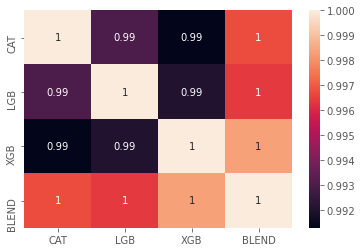

In [98]:
sns.heatmap(pd.DataFrame(np.c_[cat_pred, lgb_pred, xgb_pred, blend]**2, 
                         columns=['CAT', 'LGB', 'XGB', 'BLEND']).corr(), 
            annot=True, fmt='.2g');

In [99]:
xgb_df.to_csv(path+'/predictions/xgb3a.csv', index=False)
lgb_df.to_csv(path+'/predictions/lgb3a.csv', index=False)
cat_df.to_csv(path+'/predictions/cat3a.csv', index=False)
blend_df.to_csv(path+'/predictions/blend3a.csv', index=False)

In [135]:
gc.collect()

10948

<strong>Best Model: CatBoost

Private LB: 2382.99567372251</strong>

Blend: 2397.86844124498

LGB: 2411.87977251514

XGB: 2422.57939853213